<a href="https://colab.research.google.com/github/anshupandey/MSA-analytics/blob/main/MEM/Lab1_3_Mixed_Effect_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Module 9 – Mixed Effect Models (Labs 1–3)

**Dataset:** `Ocean_Hull_Insurance_datasetv2.csv` (provided)  
**Industry:** Ocean Hull Vessel Insurance

This notebook contains the first three labs:

- **Lab 1:** Exploring Fixed vs. Random Effects (OLS vs. Mixed-Effects)
- **Lab 2:** Hierarchical Structures & Random Slopes (Zone-level heterogeneity)
- **Lab 3:** Frequentist vs. Bayesian (template + fallback)

> ⚠️ *Note:* The provided dataset is a cross-section (one row per vessel). It **does not contain time/longitudinal repeats** per vessel. We therefore demonstrate *hierarchical* mixed-effects with group-level (Operating Zone) random effects and random slopes. For true longitudinal modelling, add a time column (e.g., policy year per vessel) and follow the template in Lab 2 (Longitudinal Note).


In [1]:

# ==== Setup ====
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pathlib import Path

# Matplotlib settings (per teaching guidelines: single-plot charts, no custom colors/styles)
%matplotlib inline

# Paths
DATA_PATH = "https://raw.githubusercontent.com/anshupandey/MSA-analytics/refs/heads/main/datasets/Ocean_Hull_Insurance_datasetv2.csv"

# Load data
df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# Quick peek
df.head()


Shape: (300, 15)
Columns: ['Vessel_ID', 'Vessel_Type', 'Operating_Zone', 'Vessel_Age', 'Flag_State', 'Inspection_Status', 'Weather_Risk', 'Piracy_Risk', 'Claim_Occurred', 'Claim_Amount', 'Premium', 'Sum_Insured', 'Daily_Return', 'Initial_Investment', 'Final_Value']


,Vessel_ID,Vessel_Type,Operating_Zone,Vessel_Age,Flag_State,Inspection_Status,Weather_Risk,Piracy_Risk,Claim_Occurred,Claim_Amount,Premium,Sum_Insured,Daily_Return,Initial_Investment,Final_Value
0,1,Container Ship,Strait of Malacca,19,Marshall Islands,Overdue,Moderate,Moderate,0,0,159500,14050000,0.000997,95700.0,104676.840752
1,2,Container Ship,Strait of Malacca,40,Marshall Islands,Up-to-date,High,High,0,0,170000,13000000,0.000362,102000.0,105374.760051
2,3,Tanker,Indian Ocean,26,Greece,Delayed,Low,Low,0,0,193000,18700000,0.001148,115800.0,128393.183954
3,4,Bulk Carrier,South China Sea,7,Greece,Up-to-date,Moderate,Low,0,0,123500,11650000,0.002023,74100.0,88881.524555
4,5,Offshore Support Vessel,Mediterranean,18,Liberia,Delayed,Low,Low,0,0,109000,7100000,0.000266,65400.0,66983.429972



## Data Processing (Used in all labs)

We will:
1. Inspect missing values.
2. Engineer a **log-claim** outcome (skew reduction): `log_claim = log(Claim_Amount + 1)`.
3. Keep key predictors (fixed effects) commonly used in insurance risk:
   - `Vessel_Age`, `Premium`, `Sum_Insured`
   - Categorical risk drivers: `Vessel_Type`, `Inspection_Status`, `Weather_Risk`, `Piracy_Risk`
4. Use **Operating_Zone** as the *grouping level* for random effects to capture unobserved spatial/operational heterogeneity.


In [2]:

# ==== Data Processing & Checks ====

# Basic NA check
na_summary = df.isna().sum().sort_values(ascending=False)
print('Missing values by column:\n', na_summary)


Missing values by column:
 Vessel_ID             0
Vessel_Type           0
Operating_Zone        0
Vessel_Age            0
Flag_State            0
Inspection_Status     0
Weather_Risk          0
Piracy_Risk           0
Claim_Occurred        0
Claim_Amount          0
Premium               0
Sum_Insured           0
Daily_Return          0
Initial_Investment    0
Final_Value           0
dtype: int64


In [3]:
# Create target for continuous modelling
df['log_claim'] = np.log1p(df['Claim_Amount'].astype(float))

# Basic sanity checks
print('\nClaim_Amount zero rate:', (df['Claim_Amount'] == 0).mean())
print('log_claim summary:\n', df['log_claim'].describe())




Claim_Amount zero rate: 0.7666666666666667
log_claim summary:
 count    300.000000
mean       3.370222
std        6.122520
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.418180
Name: log_claim, dtype: float64


In [4]:
# Ensure categorical dtypes for formula handling
categorical_cols = ['Vessel_Type', 'Operating_Zone', 'Flag_State',
                    'Inspection_Status', 'Weather_Risk', 'Piracy_Risk']
for c in categorical_cols:
    df[c] = df[c].astype('category')


# Keep a modelling frame
model_cols = ['log_claim', 'Vessel_Age', 'Premium', 'Sum_Insured',
              'Vessel_Type', 'Inspection_Status', 'Weather_Risk', 'Piracy_Risk', 'Operating_Zone']
work = df[model_cols].dropna().copy()

print('\nModelling frame shape:', work.shape)
work.head()


Modelling frame shape: (300, 9)


,log_claim,Vessel_Age,Premium,Sum_Insured,Vessel_Type,Inspection_Status,Weather_Risk,Piracy_Risk,Operating_Zone
0,0.0,19,159500,14050000,Container Ship,Overdue,Moderate,Moderate,Strait of Malacca
1,0.0,40,170000,13000000,Container Ship,Up-to-date,High,High,Strait of Malacca
2,0.0,26,193000,18700000,Tanker,Delayed,Low,Low,Indian Ocean
3,0.0,7,123500,11650000,Bulk Carrier,Up-to-date,Moderate,Low,South China Sea
4,0.0,18,109000,7100000,Offshore Support Vessel,Delayed,Low,Low,Mediterranean



### Quick EDA

We’ll examine:
- Distribution of **log_claim**
- Average claims by **Operating_Zone** (group heterogeneity glance)


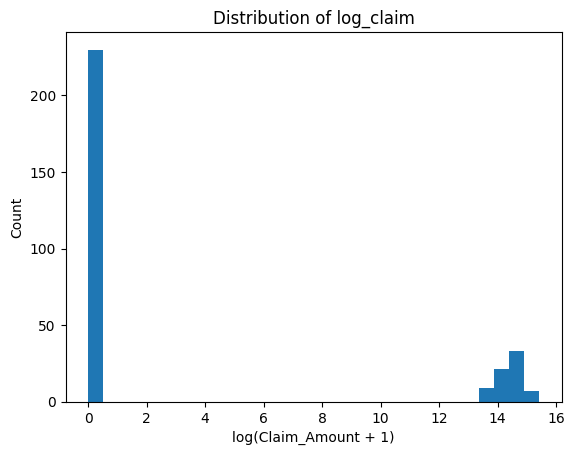

Operating_Zone
Strait of Malacca    8.024567
South China Sea      3.115020
Indian Ocean         2.403114
North Atlantic       2.046658
Mediterranean        1.415976
Name: log_claim, dtype: float64


/tmp/ipython-input-1084510661.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_means = work.groupby('Operating_Zone')['log_claim'].mean().sort_values(ascending=False)


In [5]:

# Distribution of log_claim
plt.figure()
work['log_claim'].plot.hist(bins=30)
plt.title('Distribution of log_claim')
plt.xlabel('log(Claim_Amount + 1)')
plt.ylabel('Count')
plt.show()

# Zone-level mean log_claim
zone_means = work.groupby('Operating_Zone')['log_claim'].mean().sort_values(ascending=False)
print(zone_means.head(10))



---
## Lab 1 – Exploring Fixed vs. Random Effects

**Goal:** Understand when a variable should be treated as fixed or random.  
We compare an **OLS (fixed-effects-only)** model vs. a **Mixed-Effects** model with **random intercepts by Operating_Zone**.


In [13]:


# 1) Collapse rare levels and z-scale numerics
tmp = work.copy()  # 'work' is your modelling frame from earlier

def collapse_rare(s, min_count=2, other='Other'):
    vc = s.value_counts()
    rare = vc[vc < min_count].index
    return s.apply(lambda x: other if x in rare else x).astype('category')

for cat in ['Vessel_Type','Inspection_Status','Weather_Risk','Piracy_Risk']:
    tmp[cat] = collapse_rare(tmp[cat], min_count=2)

# Drop Sum_Insured if nearly collinear with Premium
corr_ps = tmp[['Premium','Sum_Insured']].corr().iloc[0,1]
drop_sum_insured = abs(corr_ps) > 0.95

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numz = ['Vessel_Age','Premium'] + ([] if drop_sum_insured else ['Sum_Insured'])
tmp[[c+'_z' for c in numz]] = scaler.fit_transform(tmp[numz])

# 2) Fit OLS then MixedLM (random intercepts by Operating_Zone)
fe_terms = ['Vessel_Age_z','Premium_z'] + ([] if drop_sum_insured else ['Sum_Insured_z'])
fe_terms += ['C(Vessel_Type)','C(Inspection_Status)','C(Weather_Risk)','C(Piracy_Risk)']
rhs = ' + '.join(fe_terms)

ols = smf.ols(f'log_claim ~ {rhs}', data=tmp).fit()
print(ols.summary())

me = sm.MixedLM.from_formula(f'log_claim ~ {rhs}',
                             groups='Operating_Zone',
                             re_formula='1',
                             data=tmp).fit(reml=True, method='lbfgs', maxiter=200)
print(me.summary())


                            OLS Regression Results                            
Dep. Variable:              log_claim   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     70.62
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           1.26e-71
Time:                        11:03:07   Log-Likelihood:                -783.30
No. Observations:                 300   AIC:                             1589.
Df Residuals:                     289   BIC:                             1629.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


LinAlgError: Singular matrix

In [8]:
# Compare AIC
print('\nModel AIC comparison:')
print({'OLS_AIC': ols_model.aic, 'Mixed_AIC': me_model.aic})

# Visual: OLS vs Mixed fitted vs actual
plt.figure()
plt.scatter(ols_model.fittedvalues, work['log_claim'], alpha=0.6, label='OLS')
plt.title('OLS: Fitted vs. Actual (log_claim)')
plt.xlabel('Fitted')
plt.ylabel('Actual')
plt.show()

plt.figure()
plt.scatter(me_model.fittedvalues, work['log_claim'], alpha=0.6, label='Mixed')
plt.title('Mixed-Effects: Fitted vs. Actual (log_claim)')
plt.xlabel('Fitted')
plt.ylabel('Actual')
plt.show()



Model AIC comparison:


NameError: name 'me_model' is not defined


**Discussion prompts (record your notes):**
- Did the mixed model reduce AIC vs OLS?
- Which fixed effects remain significant after adding random intercepts?
- Why might **Operating_Zone** heterogeneity matter for hull insurance pricing or risk?



---
## Lab 2 – Hierarchical Structures & Random Slopes

**Goal:** Recognize *nesting* and allow relationships to vary by group.

Here, vessels are observed across different **Operating_Zone** values (many vessels per zone).  
We extend Lab 1 by allowing **zone-specific slopes for Vessel_Age**, i.e., a **random slope** for `Vessel_Age` by `Operating_Zone`.

> **Longitudinal Note:** If you add a column like `Policy_Year` (with multiple observations per vessel), the same pattern extends to *random slopes over time within vessel*; the template code is included later in this lab.


In [9]:

# ==== Lab 2: Random Slope for Vessel_Age by Operating_Zone ====
# MixedLM supports random effects design matrices (exog_re). We'll add Vessel_Age as a random slope.
# Build the random-effects design matrix with an intercept and Vessel_Age
import numpy as np
re_exog = np.column_stack([np.ones(len(work)), work['Vessel_Age'].values])
# Fit model with random intercept + random slope for Vessel_Age by Operating_Zone
me_rs = sm.MixedLM.from_formula(
    'log_claim ~ Vessel_Age + Premium + Sum_Insured + C(Vessel_Type) + C(Inspection_Status) + C(Weather_Risk) + C(Piracy_Risk)',
    groups='Operating_Zone',
    re_formula='1+Vessel_Age',
    data=work
).fit(reml=True)
print(me_rs.summary())

print('\nAIC comparison (from Lab 1 Mixed vs Random-Slope Mixed):')
print({'Mixed_AIC': float(me_model.aic), 'Mixed_RS_AIC': float(me_rs.aic)})

# Visualize random intercepts (BLUPs) for zones
ranef = me_rs.random_effects
zone_intercepts = pd.Series({k: v.values[0] if hasattr(v, 'values') else v[0] for k, v in ranef.items()})
zone_slopes = pd.Series({k: v.values[1] if hasattr(v, 'values') else v[1] for k, v in ranef.items()})

plt.figure()
zone_intercepts.sort_values().plot(kind='barh')
plt.title('Zone Random Intercepts (BLUPs)')
plt.xlabel('Intercept offset')
plt.ylabel('Operating_Zone')
plt.tight_layout()
plt.show()

plt.figure()
zone_slopes.sort_values().plot(kind='barh')
plt.title('Zone Random Slopes for Vessel_Age (BLUPs)')
plt.xlabel('Slope offset for Vessel_Age')
plt.ylabel('Operating_Zone')
plt.tight_layout()
plt.show()


LinAlgError: Singular matrix


### (Template) Longitudinal Extension – Random Slopes Over Time within Vessel

```python
# Suppose you had multiple rows per vessel with Policy_Year and claim amounts:
# df_long contains: Vessel_ID, Policy_Year, Claim_Amount, Vessel_Age, ... , Operating_Zone

df_long['log_claim'] = np.log1p(df_long['Claim_Amount'])
df_long['Policy_Year'] = df_long['Policy_Year'].astype(int)

# Random slope for time within zone, or within vessel:
m_long = sm.MixedLM.from_formula(
    'log_claim ~ Policy_Year + Vessel_Age + C(Vessel_Type)',
    groups='Vessel_ID',              # clustering at vessel level
    re_formula='1+Policy_Year',      # random slope of time
    data=df_long
).fit(reml=True)
print(m_long.summary())
```



---
## Lab 3 – Frequentist vs. Bayesian Approaches

**Goal:** Compare estimates and interval interpretations across frequentist and Bayesian frameworks.

- **Frequentist**: We already fit using `statsmodels` MixedLM.
- **Bayesian**: Below is a **template** using `PyMC`/`Bambi`. This environment may not have these libraries preinstalled. The cell checks availability and, if missing, **skips execution** but leaves **ready-to-run code** for your environment.


In [11]:
# ==== Lab 3: Frequentist vs Bayesian (Template + Fallback) ====
import importlib, sys

has_bambi = importlib.util.find_spec('bambi') is not None
has_pymc = importlib.util.find_spec('pymc') is not None

print('Has bambi:', has_bambi)
print('Has pymc:', has_pymc)


Has bambi: False
Has pymc: True


In [12]:


if has_bambi and has_pymc:
    import bambi as bmb
    # Bayesian mixed model analogous to Lab 2
    # Using weakly-informative priors by default
    model_bayes = bmb.Model(
        'log_claim ~ Vessel_Age + Premium + Sum_Insured + 1 + (1 + Vessel_Age|Operating_Zone) + '
        'C(Vessel_Type) + C(Inspection_Status) + C(Weather_Risk) + C(Piracy_Risk)',
        data=work
    )
    idata = model_bayes.fit(draws=1000, chains=2, cores=1)
    print(idata)
    # Posterior summaries
    print(model_bayes.summary())
else:
    print('\nBayesian libraries not available in this runtime.')
    print('Template code is provided below for environments with PyMC/Bambi installed.')



Bayesian libraries not available in this runtime.
Template code is provided below for environments with PyMC/Bambi installed.



### Template: Bayesian Mixed Model with PyMC (via Bambi)

```python
import bambi as bmb
model_bayes = bmb.Model(
    'log_claim ~ Vessel_Age + Premium + Sum_Insured + 1 + (1 + Vessel_Age|Operating_Zone) + '
    'C(Vessel_Type) + C(Inspection_Status) + C(Weather_Risk) + C(Piracy_Risk)',
    data=work
)
idata = model_bayes.fit(draws=2000, chains=4, cores=4)
model_bayes.summary()
# Compare: frequentist confidence intervals vs. Bayesian credible intervals.
```
